In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import ipywidgets as widgets
from matplotlib import animation
from functools import partial
slider_layout = widgets.Layout(width='600px', height='20px')
slider_style = {'description_width': 'initial'}
IntSlider_nice = partial(widgets.IntSlider, style=slider_style, layout=slider_layout, continuous_update=False)
FloatSlider_nice = partial(widgets.FloatSlider, style=slider_style, layout=slider_layout, continuous_update=False)
SelSlider_nice = partial(widgets.SelectionSlider, style=slider_style, layout=slider_layout, continuous_update=False)

# Redes Convolucionales

[Slides 49-88](https://docs.google.com/presentation/d/1IJ2n8X4w8pvzNLmpJB-ms6-GDHWthfsJTFuyUqHfXg8/edit#slide=id.g3a1a71fe7e_8_192)

# Red Convolucional en PyTorch

Las redes neuronales convolucionales utilizan principalmente tres tipos de capas

## [Capas convolucionales](https://pytorch.org/docs/stable/nn.html#convolution-layers)

- Las neuronas de estas capas se organizan en filtros 
- Se realiza la correlación cruzada entre la imagen de entrada y los filtros
- Existen capas convolucionales 1D, 2D y 3D


[Visualización de convoluciones con distintos tamaños, strides, paddings, dilations](https://github.com/vdumoulin/conv_arithmetic)

Los argumentos de la capa convolución de dos dimensiones son:

```python
torch.nn.Conv2d(in_channels, #Cantidad de canales de la imagen de entrada
                out_channels, #Cantidad de bancos de filtro
                kernel_size, #Tamaño de los filtros (entero o tupla)
                stride=1, #Paso de los filtros
                padding=0, #Cantidad de filas y columnas para agregar a la entrada antes de filtrar
                dilation=1, #Espacio entre los pixeles de los filtros
                groups=1, #Configuración cruzada entre filtros de entrada y salida
                bias=True,  #Utilizar sesgo (b)
                padding_mode='zeros' #Especifica como agregar nuevas filas/columnas (ver padding)
                )
```

## [Capas de pooling](https://pytorch.org/docs/stable/nn.html#pooling-layers)

- Capa que reduce la dimensión (tamaño) de su entrada
- Se usa tipicamente luego de una capa de convolución "activada"
- Realiza una operación no entrenable: 
    - Promedio de los píxeles en una región (kernel_size=2, stride=2)
    
            1 2 1 0
            2 3 1 2      2.00 1.00
            0 1 0 1      0.75 0.25
            2 0 0 0
            
    - Máximo de los pixeles en una región (kernel_size=2, stride=2)
   
            1 2 1 0
            2 3 1 2      3 2
            0 1 0 1      2 1
            2 0 0 0
- Estas capas ayudan a reducir la complejidad del modelo
- También otorgan "invarianza local a la traslación", es decir que la posición donde estaba el patrón es menos relevante luego de aplicar pooling

Los argumentos de MaxPooling para entradas de dos dimensiones son:

```python
torch.nn.MaxPool2d(kernel_size, # Mismo significado que en Conv2d
                   stride=None, # Mismo significado que en Conv2d
                   padding=0, #Mismo significado que en Conv2d
                   dilation=1, #Mismo significado que en Conv2d
                   return_indices=False, #Solo necesario para hacer unpooling
                   ceil_mode=False #Usar ceil en lugar de floor para calcular el tamaño de la salida
                  )
```

## [Capas completamente conectadas](https://pytorch.org/docs/stable/nn.html#torch.nn.Linear)

- Idénticas a las usadas en redes tipo MLP
- Realizan la operación: $Z = WX + b$

Los argumentos son:

```python
torch.nn.Linear(in_features, #Neuronas en la entrada
                out_features,  #Neuronas en la salida
                bias=True  #Utilizar sesgo (b)
                )
```

# [Torchvision](https://pytorch.org/docs/stable/torchvision/index.html)

Es una librería utilitaria de PyTorch que facilita considerablemente el trabajo con imágenes

- Funcionalidad para descargar sets de benchmark: MNIST, CIFAR, IMAGENET, ...
- Modelos clásicos pre-entrenados: Lenet5, AlexNet
- Funciones para importar imágenes en distintos formatos
- Funciones de transformación para hacer aumentación de datos en imágenes

## Ejemplo: Base de datos de imágenes de dígitos manuscritos MNIST

- Imágenes de 28x28 píxeles en escala de grises
- Diez categorías: Dígitos manuscritos del cero al nueve
- 60.000 imágenes de entrenamiento, 10.000 imágenes de prueba
- Por defecto las imágenes vienen en [formato PIL](https://pillow.readthedocs.io/en/stable/) (entero 8bit), usamos la transformación [`ToTensor()`](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.ToTensor) para convertirla a tensor en float32

60000

torch.Tensor

torch.float32

int

<IPython.core.display.Javascript object>


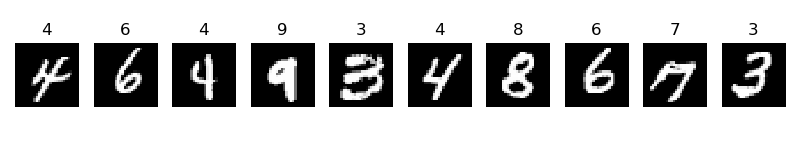

In [2]:
import torchvision

mnist_train_data = torchvision.datasets.MNIST(root='~/datasets/',
                                              train=True, download=True, 
                                              transform=torchvision.transforms.ToTensor())

mnist_test_data = torchvision.datasets.MNIST(root='~/datasets/',
                                             train=False, download=True, 
                                             transform=torchvision.transforms.ToTensor())

image, label = mnist_train_data[0]
display(len(mnist_train_data), type(image), image.dtype, type(label))
fig, ax = plt.subplots(1, 10, figsize=(8, 1.5), tight_layout=True)
idx = np.random.permutation(len(mnist_train_data))[:10]
for k in range(10):
    image, label = mnist_train_data[idx[k]]
    ax[k].imshow(image[0, :, :].numpy(), cmap=plt.cm.Greys_r)
    ax[k].axis('off');
    ax[k].set_title(label)

## Dataloaders

Creamos dataloaders de entrenamiento y validación

In [3]:
from torch.utils.data import Subset, DataLoader
import sklearn.model_selection

# Set de entrenamiento y validación estratíficados
sss = sklearn.model_selection.StratifiedShuffleSplit(train_size=0.75).split(mnist_train_data.data, 
                                                                            mnist_train_data.targets)
train_idx, valid_idx = next(sss)

# Data loader de entrenamiento
train_dataset = Subset(mnist_train_data, train_idx)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32)

# Data loader de validación
valid_dataset = Subset(mnist_train_data, valid_idx)
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=256)

# Mi primera red convolucional para clasificar en pytorch

Clasificaremos la base de datos MNIST 

Para esto implementaremos la clásica arquitectura Lenet5

<img src="img/LeNet5.png" width="800">

La arquitectura considera
- Dos capas convolucionales con 8 y 16 bancos de filtros, respectivamente
- Las capas convolucionales usan filtros de 5x5 píxeles
- Se usa max-pooling de tamaño 2x2 y stride 2
- La primera capa convolucional espera un minibatch de imágenes de 1 canal (blanco y negro)
- Usaremos la función de activación [Rectified Linear Unit (ReLU)](https://pytorch.org/docs/stable/nn.html#relu)
- Se usan tres capas completamente conectadas con 120, 84 y 10 neuronas, respectivamente

> Podemos usar `reshape` o `view` para convertir un tensor de 4 dimensiones a dos dimensiones.  Esto prepara un tensor que sale de una capa convolucional (o pooling) para ingresarlo a las capas completamente conectadas

In [6]:
import torch

class Lenet5(torch.nn.Module):
    
    def __init__(self, n_hidden=20, n_filters=8):
        super(type(self), self).__init__()
        # Completar
        pass
        
    def forward(self, x):
        # Completar
        pass
    
model = Lenet5()
display(model)

model.forward(mnist_train_data[0][0].unsqueeze(0))

Lenet5()

### Clasificación multiclase en PyTorch

Para hacer clasificación con **más de dos categorías** usamos la [entropía cruzada](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss)

```python
    torch.nn.CrossEntropyLoss()
```

- Si el problema de clasificación es de $M$ categorías la última capa de la red debe tener $M$ neuronas
- Adicionalmente no se debe usar función de activación ya que `CrossEntropyLoss` la aplica de forma interna

Para evaluar la red debemos aplicar de forma manual 
- `torch.nn.Softmax(dim=1)`
- `torch.nn.LogSoftmax(dim=1)`

a la salida de la red

> Luego podemos usar el atributo `argmax(dim=1)` para encontrar la clase más probable

### Gradiente descendente con paso adaptivo

Para acelerar el entrenamiento podemos usar un algoritmo de [gradiente descendente con paso adaptivo](https://arxiv.org/abs/1609.04747)

Un ejemplo ampliamente usado es [Adam](https://arxiv.org/abs/1412.6980)

- Se utiliza la historia de los gradientes
- Se utiliza momentum (inercia)
- Cada parámetro tiene un paso distinto

```python
    torch.optim.Adam(params,  **Parámetros de la red neuronal**
                     lr=0.001,  **Tasa de aprendizaje inicial**
                     betas=(0.9, 0.999),  **Factores de olvido de los gradientes históricos**
                     eps=1e-08, **Término para evitar división por cero**
                     weight_decay=0, **Regulariza los pesos de la red si es mayor que cero**
                     amsgrad=False **Corrección para mejorar la convergencia de Adam en ciertos casos**
                     )
```

**Atención**

Esta es un área de investigación activa. [Papers recientes indican que Adam llega a un óptimo más rápido que SGD, pero ese óptimo podría no ser mejor que el obtenido por SGD](https://arxiv.org/abs/1712.07628)

> Siempre prueba tus redes con distintos optimizadores


# Entrenamiento de la red convolucional

- Si tenemos acceso a una GPU podemos usar el atributo `.cuda()` o `.to()` para enviar el modelo y los datos a la GPU para acelerar los cálculos
- Actualizamos los parámetros en el conjunto de entrenamiento
- Medimos la convergencia en el conjunto de validación
- Guardamos el modelo con mejor eror de validación
- Usaremos [tqdm](https://tqdm.github.io/) para medir el tiempo por iteración dentro de jupyter. Instalar con [conda](https://anaconda.org/conda-forge/tqdm) o [pip](https://pypi.org/project/tqdm/)


### Visualización de entrenamiento usando tensorboard

Podemos usar la herramienta [tensorboard](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html) para visualizar el entrenamiento de la red en vivo y/o comparar distintos entrenamientos

- Instalar tensorboard versión 1.15 o mayor con [conda](https://anaconda.org/conda-forge/tensorboard) o pip

- Escribir en un terminal

        tensorboard --logdir=/tmp/tensorboard/

- Apuntar el navegador a 

        https://localhost:6006 
            


In [ ]:
import time
from tqdm import tqdm_notebook
from torch.utils.tensorboard import SummaryWriter

use_gpu = False
nepochs = 100
best_valid = np.inf
writer = SummaryWriter(log_dir="/tmp/tensorboard/red_convolucional_simple/"+str(time.time_ns()),
                       flush_secs=20)

# Enviar modelo a la GPU
if use_gpu:
    nnet = nnet.cuda()
    
criterion = torch.nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)

for k in tqdm_notebook(range(nepochs)): 
    # Entrenamiento
    epoch_loss, epoch_acc = 0.0, 0.0
    for mbdata, mblabel in train_loader:
        if use_gpu:
            mbdata, mblabel = mbdata.cuda(), mblabel.cuda()
        # Inferencia
        prediction = model.forward(mbdata)
        # Estimar el error
        loss = criterion(prediction, mblabel)  
        epoch_loss += loss.item()
        epoch_acc += (torch.nn.Softmax(dim=1)(prediction).argmax(dim=1) == mblabel).sum().item()        
        # Calcular gradientes
        optimizer.zero_grad()        
        loss.backward()
        # Actualizar parámetros
        optimizer.step()
    # Enviar información a tensorboard
    writer.add_scalar('Train/Loss', epoch_loss/len(train_idx), k)
    writer.add_scalar('Train/Acc', epoch_acc/len(train_idx), k)
    # Validación
    epoch_loss, epoch_acc = 0.0, 0.0
    for mbdata, mblabel in valid_loader:
        if use_gpu:
            mbdata, mblabel = mbdata.cuda(), mblabel.cuda()
        # Inferencia
        prediction = model.forward(mbdata)
        # Estimar el error
        loss = criterion(prediction, mblabel)  
        epoch_loss += loss.item()
        epoch_acc += (torch.nn.Softmax(dim=1)(prediction).argmax(dim=1) == mblabel).sum().item()        
    # Enviar información a tensorboard
    writer.add_scalar('Valid/Loss', epoch_loss/len(valid_idx), k)
    writer.add_scalar('Valid/Acc', epoch_acc/len(valid_idx), k)
    
    if k % 5 == 0:
        if epoch_loss/len(valid_idx) < best_valid:
            best_valid = epoch_loss/len(valid_idx)
            torch.save({'epoca': k,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),                        
                        'loss': epoch_loss/len(valid_idx)}, 
                       '/home/phuijse/models/best_model.pt') # MODIFICA LA RUTA 

# Retornar modelo a la CPU
if use_gpu:
    nnet = model.cpu()
    
writer.close()

### Evaluando la red en el conjunto de test

Primero recuperamos la mejor red

In [ ]:
model = mi_red_convolucional()

model.load_state_dict(torch.load('/home/phuijse/models/best_model.pt')['model_state_dict'])

Para clasificar un ejemplo de test debemos pasar la salida por una activación SoftMax

In [ ]:
image, label = mnist_test_data[np.random.randint(1000)]
# Usamos unsqueeze para convertirlo en un minibatch de 1 elemento:
y = torch.nn.Softmax(dim=1)(model.forward(image.unsqueeze(0)))

fig, ax = plt.subplots(1, 2, figsize=(5, 3))
ax[0].bar(range(10), height=y.detach().numpy()[0])
ax[0].set_xticks(range(10))
ax[1].set_title("Etiqueta: %d" %(label))
ax[1].imshow(image.numpy()[0, :, :], cmap=plt.cm.Greys_r);
ax[1].axis('off');

Podemos evaluar la red en el conjunto de prueba y construir una tabla de confusión

In [ ]:
test_loader = DataLoader(mnist_test_data, shuffle=False, batch_size=512)
test_targets = mnist_test_data.targets.numpy()
prediction_test = []
for mbdata, label in test_loader:
    logits = model.forward(mbdata)
    prediction_test.append(torch.argmax(logits, dim=1).detach().numpy())

prediction_test = np.concatenate(prediction_test)

from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(test_targets, prediction_test)
display(cm)

print(classification_report(test_targets, prediction_test))

Una tarea muy importante es analizar los errores de la red

- Buscar ejemplos que estaban mal etiquetados
- Proponer mejoras (nuevos atributos, capas, etc)

Por ejemplo si visualizamos los que deberían ser $7$ pero son clasificados como otro dígito

In [ ]:
idx = np.where((test_targets == 9) & ~(prediction_test == 9))[0]

fig, ax = plt.subplots(1, 10, figsize=(8, 2), tight_layout=True)
for i in range(10):
    ax[i].imshow(mnist_test_data[idx[i]][0].numpy()[0, :, :], cmap=plt.cm.Greys_r)
    ax[i].set_title(prediction_test[idx[i]])
    ax[i].axis('off')

### Visualizando los filtros aprendidos

In [ ]:
fig, ax = plt.subplots(1, 8, figsize=(7, 2), tight_layout=True)
w = model.conv1.weight.data.numpy()

for i in range(8):    
    ax[i].imshow(w[i, 0, :, :])
    ax[i].axis('off')

# Aumentación de datos

Si tenemos un dataset de imágenes muy pequeño y la red que estamos entrenando se está sobreajustando podemos intentar incrementarlo usando **transformaciones**

Si rotamos, trasladamos o cambiamos el brillo de una imagen obtendremos una nueva imagen "casi siempre" de la misma clase

*torchvision* tiene funciones implementadas para hacer transformaciones:

- [Rotación aleatoria](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.RandomRotation)
- [Espejamiento aleatorio](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.RandomHorizontalFlip)
- [Cropping aleatorio](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.RandomCrop): Recortar la imagen
- [Cambios aleatorios de brillo y contraste](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.ColorJitter)
- [Transformación afin aleatoria](https://pytorch.org/docs/stable/torchvision/transforms.html)
- [entre otros](https://pytorch.org/docs/stable/torchvision/transforms.html)

Cada transformación permite especificar límites, por ejemplo "máximo ángulo de rotación", "máxima distorsión de brillo", etc

Las transformaciones también sirven para hacer que la red gane "invarianzas"

**Ejemplo:** Si entrenamos con copias rotadas de nuestras imágenes, la red se volverá invariante a la rotación

### ATENCIÓN

> Las transformaciones que apliquemos no deben cambiar la interpretación de clase

- Si rotas un seis en 180 grados se convierte en un nueve
- Si cambias demasiado el tono (hue) podrías obtener colores distintos a la realidad (perro verde?)

### Transformaciones aleatorias con [torchvision](https://pytorch.org/docs/stable/torchvision/transforms.html)

La mayoría de las transformaciones están diseñadas para aplicarse sobre imágenes en formato PIL

Podemos componer varias transformaciones usando [`torchvision.transforms.Compose`](https://pytorch.org/docs/stable/torchvision/transforms.html)

In [ ]:
import urllib
url, filename = ("https://i.kym-cdn.com/photos/images/newsfeed/000/674/934/422.jpg", "dog.jpg")
urllib.request.urlretrieve(url, filename)

from PIL import Image

img = Image.open("dog.jpg")

transform = torchvision.transforms.Compose([torchvision.transforms.Resize(200),
                                            torchvision.transforms.RandomHorizontalFlip(),
                                            torchvision.transforms.RandomRotation(degrees=30),
                                            torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, 
                                                                               saturation=0.5, hue=0.0),
                                           ])

display(torchvision.transforms.Resize(200)(img))
display(transform(img))

## Entrenando con datos aumentados

Podemos componer una transformación y añadirla a un dataset

Luego cuando usamos el dataloader se generaran imágenes con transformaciones aleatorias



### IMPORTANTE: SOLO SE AUMENTA EL CONJUNTO DE ENTRENAMIENTO

In [ ]:
transform = torchvision.transforms.Compose([torchvision.transforms.RandomAffine(degrees=30, translate=(0.2, 0.2), 
                                                                                scale=(0.5, 1.5), shear=None, 
                                                                                resample=False, fillcolor=0),
                                            torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, 
                                                                               saturation=0.5, hue=0.0),
                                            torchvision.transforms.ToTensor()
                                           ])

mnist_train_data = torchvision.datasets.MNIST(root='/home/phuijse/datasets/',
                                             train=True, download=True, 
                                             transform=transform)

train_loader = DataLoader(mnist_train_data, shuffle=False, batch_size=32)

for image, label in train_loader:
    break

fig, ax = plt.subplots(4, 8, figsize=(7, 4), tight_layout=True)
for k in range(32):
    i, j = np.unravel_index(k, (4, 8))
    ax[i, j].axis('off')
    ax[i, j].set_title(label[k].numpy())
    ax[i, j].imshow(image[k].numpy()[0, :, :], cmap=plt.cm.Greys_r)

# Utilizando un modelo pre-entrenado

[`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html) ofrece una serie de modelos famosos de la literatura de *deep learning*

Por defecto el modelo se carga con pesos aleatorios

Se pueden escoger modelos para clasificar, localizar y segmentar

Si indicamos `pretrained=True` se descarga un modelo entrenado

Por ejemplo, podemos cargar [resnet18](https://arxiv.org/pdf/1512.03385.pdf) [pre-entrenado](https://pytorch.org/docs/stable/torchvision/models.html#torchvision.models.resnet18) en [ImageNet](http://image-net.org/) 

In [ ]:
resnet_model = torchvision.models.resnet18(pretrained=True, progress=True)
resnet_model.eval()

Los modelos pre-entrenados esperan imágenes con
- tres canales (RGB)
- al menos 224x224 píxeles
- píxeles entre 0 y 1 (float)
- normalizadas con 

        normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])



In [ ]:
url, filename = ("https://github.com/pytorch/hub/raw/master/dog.jpg", "dog.jpg")
urllib.request.urlretrieve(url, filename)

img = Image.open("dog.jpg")

transform = torchvision.transforms.Compose([torchvision.transforms.Resize(256),
                                            torchvision.transforms.CenterCrop(224),
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), 
                                                                             std=(0.229, 0.224, 0.225))])

# La clase con probabilidad más alta
resnet_model.forward(transform(img).unsqueeze(0)).argmax(dim=1)

¿A qué corresponde esta clase?

Clases de ImageNet: https://gist.github.com/ageitgey/4e1342c10a71981d0b491e1b8227328b

¿y la imagen que era?

In [ ]:
img

# Resumen

Aspectos a considerar durante el entrenamiento de redes neuronales
- Arquitecturas (cantidad y organización de capas, funciones de activación)
- Funciones de costo y Optimizadores (tasa de aprendizaje)
- Verificar convergencia y sobreajuste:
    - Siempre ir guardando el mejor modelo en validación (checkpoint)
    - Detener el entrenamiento si el error de validación no disminuye 
- Inicialización de los parámetros: Probar varios entrenamientos desde inicios aleatorios distintos
- Normalización de entrada y normalización capa a capa ([batch-normalization](https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm2d))
- Si el modelo se sobreajusta pronto
    - Disminuir complejidad
    - Regularizar (Aumentación de datos, penalización de los pesos, Dropout)
- Si quiero aprovechar un modelo preentrenado
    - Transferencia de aprendizaje
    - [Zoológico de modelos](https://modelzoo.co/)


# Transferencia de Aprendizaje

Ajuste fino de un modelo pre-entrenado

FUTURO

# Localización y segmentación

Encontrar y segmentar objetos en imágenes

FUTURO